In [42]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
# needed to let jupyter find the module...
sys.path.append('/Users/toastcheng/Desktop/MLDS/lib/python3.6/site-packages/')

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
%matplotlib inline

In [62]:
BATCH_SIZE = 256
LR = 5e-4
EPOCH = 50
np.random.seed(1)
torch.manual_seed(1)
CUDA= torch.cuda.is_available()

## Load Data

In [63]:
train_data = torchvision.datasets.MNIST(root="./data/mnist/",
                                       train=True,
                                       transform=torchvision.transforms.ToTensor(),
                                       download=True)
test_data = torchvision.datasets.MNIST(root="./data/mnist/",
                                      train=False)
train_loader = data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

## Define Model Structure

In [64]:
class CNN_shallow(nn.Module):
    def __init__(self):
        super(CNN_shallow, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 66, 7, 1, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ) # m * 19 * 14 * 14
        self.fc1 = nn.Linear(66 * 14 * 14, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


class CNN_deep(nn.Module):
    def __init__(self):
        super(CNN_deep, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
         # m * 8 * 14 * 14
            nn.Conv2d(32, 48, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
         # m * 16 * 7 * 7
            nn.Conv2d(48, 72, 5, 2, 1),
            nn.ReLU(),
        ) # m * 39 * 3 * 3
        self.fc1 = nn.Linear(72 * 3 * 3, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


class CNN_deeper(nn.Module):
    def __init__(self):
        super(CNN_deeper, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # m * 5 * 14 * 14
            nn.Conv2d(20, 36, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # m * 10 * 7 * 7
            nn.Conv2d(36, 62, 5, 1, 1),
            nn.ReLU(),
            # m * 15 * 5 * 5
            nn.Conv2d(62, 74, 3, 1, 0),
            nn.ReLU(),
            # m * 18 * 3 * 3
            nn.Conv2d(74, 102, 1, 1, 0),
            nn.ReLU(),
            # m * 22 * 3 * 3

        )
        self.fc1 = nn.Linear(102 * 3 * 3, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

## Set Optimizer and loss

In [65]:
shallow = CNN_shallow()
deep = CNN_deep()
deeper = CNN_deeper()
if CUDA:
    shallow= shallow.cuda()
    deep= deep.cuda()
    deeper= deeper.cuda()
optim_shallow = optim.Adam(params=shallow.parameters(),lr=LR)
optim_deep = optim.Adam(params=deep.parameters(),lr=LR)
optim_deeper = optim.Adam(params=deeper.parameters(),lr=LR)
loss_func = nn.CrossEntropyLoss()
print(shallow)
print(deep)
print(deeper)

CNN_shallow(
  (conv1): Sequential(
    (0): Conv2d(1, 66, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (fc1): Linear(in_features=12936, out_features=10, bias=True)
)
CNN_deep(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(48, 72, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (fc1): Linear(in_features=648, out_features=10, bias=True)
)
CNN_deeper(
  (conv1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), strid

## Count the parameters in each model

In [66]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_shallow = count_parameters(shallow)
count_deep = count_parameters(deep)
count_deeper = count_parameters(deeper)

print("parameters in shallow model:")
print(count_shallow)
print("parameters in deep model:")
print(count_deep)
print("parameters in deeper model:")
print(count_deeper)

parameters in shallow model:
132670
parameters in deep model:
132242
parameters in deeper model:
132624


## Train

In [67]:
print('start')
loss_shallow_list = []
loss_deep_list = []
loss_deeper_list = []
acc_shallow_list= []
acc_deep_list= []
acc_deeper_list= []
for epoch in range(EPOCH):
    for idx, (x, y) in enumerate(train_loader):
        if CUDA:
            x, y= x.cuda(), y.cuda()
        x, y= Variable(x), Variable(y)
        #shallow
        pred_shallow = shallow(x)
        loss_shallow = loss_func(pred_shallow, y)
        optim_shallow.zero_grad()
        loss_shallow.backward()
        optim_shallow.step()
        loss_shallow_list.append(loss_shallow.data[0])
        
        #deep
        pred_deep = deep(x)
        loss_deep = loss_func(pred_deep, y)
        optim_deep.zero_grad()
        loss_deep.backward()
        optim_deep.step()
        loss_deep_list.append(loss_deep.data[0])
        
        #deeper
        pred_deeper = deeper(x)
        loss_deeper = loss_func(pred_deeper, y)
        optim_deeper.zero_grad()
        loss_deeper.backward()
        optim_deeper.step()
        loss_deeper_list.append(loss_deeper.data[0])

        #record acc
        acc_shallow_list.append(sum(torch.max(pred_shallow, 1)[1].data.squeeze() == y.data)/float(y.size(0)))
        acc_deep_list.append(sum(torch.max(pred_deep, 1)[1].data.squeeze() == y.data)/float(y.size(0)))
        acc_deeper_list.append(sum(torch.max(pred_deeper, 1)[1].data.squeeze() == y.data)/float(y.size(0)))
        
        if idx % 100 == 0:
            pred_shallow = torch.max(pred_shallow, 1)[1].data.squeeze()
            pred_deep = torch.max(pred_deep, 1)[1].data.squeeze()
            pred_deeper = torch.max(pred_deeper, 1)[1].data.squeeze()

            acc_shallow = sum(pred_shallow == y.data)/float(y.size(0))
            acc_deep = sum(pred_deep == y.data)/float(y.size(0))
            acc_deeper = sum(pred_deeper == y.data)/float(y.size(0))
            

            print("epoch: %2d | batch: %4d | shallow acc: %.4f | deep acc: %.4f | deeper acc: %.4f"
                 % (epoch, idx, acc_shallow, acc_deep, acc_deeper))
print('end of training')
        

start
epoch:  0 | batch:    0 | shallow acc: 0.1484 | deep acc: 0.0664 | deeper acc: 0.0508
epoch:  0 | batch:  100 | shallow acc: 0.9648 | deep acc: 0.9531 | deeper acc: 0.9492
epoch:  0 | batch:  200 | shallow acc: 0.9375 | deep acc: 0.9375 | deeper acc: 0.9180
epoch:  1 | batch:    0 | shallow acc: 0.9258 | deep acc: 0.9492 | deeper acc: 0.9297
epoch:  1 | batch:  100 | shallow acc: 0.9609 | deep acc: 0.9531 | deeper acc: 0.9453
epoch:  1 | batch:  200 | shallow acc: 0.9727 | deep acc: 0.9688 | deeper acc: 0.9688
epoch:  2 | batch:    0 | shallow acc: 0.9648 | deep acc: 0.9766 | deeper acc: 0.9570
epoch:  2 | batch:  100 | shallow acc: 0.9844 | deep acc: 0.9883 | deeper acc: 0.9883
epoch:  2 | batch:  200 | shallow acc: 0.9805 | deep acc: 0.9883 | deeper acc: 0.9844
epoch:  3 | batch:    0 | shallow acc: 0.9961 | deep acc: 0.9961 | deeper acc: 0.9883
epoch:  3 | batch:  100 | shallow acc: 0.9844 | deep acc: 0.9883 | deeper acc: 0.9883
epoch:  3 | batch:  200 | shallow acc: 0.9688 | 

## Loss\Acc Visualization

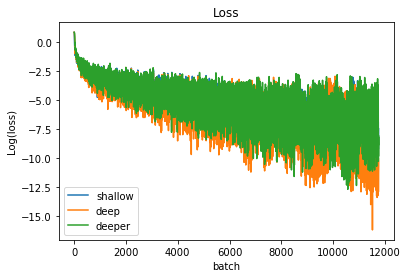

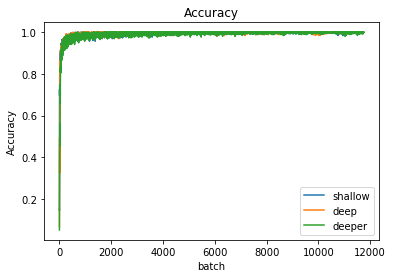

In [70]:
num_show = 11750
plt.plot(np.arange(num_show), np.log(np.array(loss_shallow_list[:num_show])), label='shallow')
plt.plot(np.arange(num_show), np.log(np.array(loss_deep_list[:num_show])), label='deep')
plt.plot(np.arange(num_show), np.log(np.array(loss_deeper_list[:num_show])), label='deeper')
plt.title('Loss')
plt.xlabel('batch')
plt.ylabel('Log(loss)')
plt.legend()
plt.show()

plt.plot(np.arange(num_show), np.array(acc_shallow_list[:num_show]), label='shallow')
plt.plot(np.arange(num_show), np.array(acc_deep_list[:num_show]), label='deep')
plt.plot(np.arange(num_show), np.array(acc_deeper_list[:num_show]), label='deeper')
plt.title('Accuracy')
plt.xlabel('batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Little Test

shallow: 8 | deep: 8 | deeper: 8
shallow: 8 | deep: 8 | deeper: 8
shallow: 2 | deep: 2 | deeper: 2
shallow: 7 | deep: 7 | deeper: 7
shallow: 9 | deep: 9 | deeper: 9


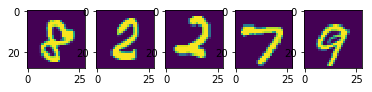

In [46]:
fig, axes = plt.subplots(1,5)
for num, ax in enumerate(axes):
    ax.imshow(x.data[num][0])
    tmp1 = int(torch.max(shallow(x[num:num+1]), 1)[1])
    tmp2 = int(torch.max(deep(x[num:num+1]), 1)[1])
    tmp3 = int(torch.max(deeper(x[num:num+1]), 1)[1])
    print("shallow: %d | deep: %d | deeper: %d" % (tmp1, tmp2, tmp3))